# 使用seq2seq网络和注意力机制来实现机器翻译

本示例会介绍使用seq2seq网络来实现机器翻译，同时使用注意力机制来提高seq2seq的效果(尤其是长句)。

## sequence to sequence模型

sequence to sequence模型，或者说seq2seq模型，由两个RNN组成。这两个RNN分别叫做encoder和decoder。
encoder会一个词一个出的读入输入序列，每一步都有一个输出，而最后的输出叫做context向量，我们可以认为是模型对源语言句子“语义”的一种表示。而decoder用这个context向量一步一步的生成目标语言的句子。

![](seq2seq.png)

为什么要两个RNN呢，如果我们使用一个RNN，输入和输出是一对一的关系（对于分类，我们可以只使用最后一个输出），但是翻译肯定不是一个词对一个词的翻译。当然这只是使用两个RNN在形式上的方便，从“原理”上来说，人类翻译也是类似的，首先仔细阅读源语句，然后“理解”它，而所谓的“理解”在seq2seq模型里可以认为encoding的过程，然后再根据理解，翻译成目标语句。


## 注意力机制

用一个固定长度的向量来承载输入序列的完整“语义”，不管向量能有多长，都是很困难的事情。

[Bahdanau et al.等人引入的](https://arxiv.org/abs/1409.0473) **注意力机制**试图这样来解决这个问题：我们不依赖于一个固定长度的向量，而是通过“注意”输入的某些部分。在decoer每一步解码的时候都通过这个机制来选择输入的一部分来重点考虑。这似乎是合乎人类的翻译过程的——我们首先通过一个encoder大致理解句子的意思（编码到一个定长向量），具体翻译某个词或者短语的时候我们会仔细推敲对应的源语言的词（注意力机制）。

![](5y6SCvU.png)

注意力是通过decoder的另外一个神经网络层来计算的。它的输入是当前输入和上一个时刻的隐状态，输出是一个新的向量，这个向量的长度和输入相同（因为输入是变长的，我们会选择一个最大的长度），这个向量会用softmax变成“概率”，得到*注意力权重*，这个权重可以认为需要花费多大的“注意力”到某个输入上，因此我们会用这个权重加权平均encoder的输出，从而得到一个新的context向量，这个向量会用来预测当前时刻的输出。

![](K1qMPxs.png)

## 依赖

In [1]:
import unicodedata
import string
import re
import random
import time
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

In [2]:
#如果没有GPU请改成False
USE_CUDA = True

## 加载数据

训练数据是几千个英语到法语的平行句对。我们这里只是介绍算法，所以使用一个很小的数据集来演示。数据在data/eng-fra.txt里，格式如下：
```
I am cold.    Je suis froid.
```
我们会用one-hot的方法来表示一个单词。

### 单词变成数字
我们会创建一个Lang对象来表示源/目标语言，它包含word2idx、idx2word和word2count，分别表示单词到id、id到单词和单词的词频。
word2count的作用是用于过滤一些低频词（把它变成unknown）

In [3]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2
      
    def index_words(self, sentence):
        for word in sentence.split(' '):
            self.index_word(word)

    def index_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [4]:
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# 大小转小写，trim，去掉非字母。
def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

### 读取文件

文件格式是每行一个句对，用tab分隔，第一个是英语，第二个是法语，为了方便未来的复用，我们有一个reverse参数，这样如果我们需要法语到英语的翻译就可以用到。

In [5]:
def read_langs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # 读取文件
    lines = open('../data/%s-%s.txt' % (lang1, lang2)).read().strip().split('\n')
    
    # split
    pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]
    
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
        
    return input_lang, output_lang, pairs

### 过滤句子

作为演示，我们只挑选长度小于10的句子，并且这保留"I am"和"He is"开头的数据

In [6]:
MAX_LENGTH = 10

good_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re "
)

def filter_pair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(good_prefixes)

def filter_pairs(pairs):
    return [pair for pair in pairs if filter_pair(pair)]

数据处理过程如下：

* 读取文件，split成行，再split成pair
* 文本归一化，通过长度和内容过滤
* 通过pair里的句子得到单词列表

In [7]:
def prepare_data(lang1_name, lang2_name, reverse=False):
    input_lang, output_lang, pairs = read_langs(lang1_name, lang2_name, reverse)
    print("Read %s sentence pairs" % len(pairs))
    
    pairs = filter_pairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    
    print("Indexing words...")
    for pair in pairs:
        input_lang.index_words(pair[0])
        output_lang.index_words(pair[1])

    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepare_data('eng', 'fra', True)
 
print(random.choice(pairs))

Reading lines...
Read 149861 sentence pairs
Trimmed to 9738 sentence pairs
Indexing words...
['il a la grippe .', 'he s got the flu .']


## 把训练数据变成Tensor/Variable

为了让神经网络能够处理，我们首先需要把句子变成Tensor。每个句子首先分成词，每个词被替换成对应的index。另外我们会增加一个特殊的EOS来表示句子的结束。

![](https://i.imgur.com/LzocpGH.png)

在PyTorch里一个Tensor是一个多维数组，它的所有元素的数据类型都是一样的。我们这里使用LongTensor来表示词的index。

可以训练的PyTorch模块要求输入是Variable而不是Tensor。变量除了包含Tensor的内容之外，它还会跟踪计算图的状态，从而可以进行自动梯度的求值。


In [8]:
def indexes_from_sentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def variable_from_sentence(lang, sentence):
    indexes = indexes_from_sentence(lang, sentence)
    indexes.append(EOS_token)
    var = Variable(torch.LongTensor(indexes).view(-1, 1))

    if USE_CUDA: var = var.cuda()
    return var

def variables_from_pair(pair):
    input_variable = variable_from_sentence(input_lang, pair[0])
    target_variable = variable_from_sentence(output_lang, pair[1])
    return (input_variable, target_variable)

## 构建模型

### Encoder

<img src="./encoder-network.png" style="float: right" />

seq2seq网络的encoder是一个RNN，对于输入的每一个词都输出一个向量和一个隐状态，这个隐状态会作为下一个时刻的输入。

In [9]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        
    def forward(self, word_inputs, hidden):
        # 注意：和名字分类不同，我们这里一次处理完一个输入的所有词，而不是for循环每次处理一个词。
        # 两者的效果是一样的，但是一次处理万效率更高。
        seq_len = len(word_inputs)
        embedded = self.embedding(word_inputs).view(seq_len, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def init_hidden(self):
        hidden = Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
        if USE_CUDA: hidden = hidden.cuda()
        return hidden

## Attention Decoder

### 理解Bahdanau等人提出的模型

下面我们来学习一下这篇文章提出的 [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473) Attention Decoder。

decoder在每一个时刻的输出依赖与前一个时刻的输出和一个$\mathbf x$，这个$\mathbf x$包括当前的隐状态（它也会考虑前一个时刻的输出）和一个注意力”context“，下文会介绍它。函数$g$是一个带非线性激活的全连接层，它的输入是$y_{i-1}$, $s_i$ 和 $c_i$拼接起来的。

$$
p(y_i \mid \{y_1,...,y_{i-1}\},\mathbf{x}) = g(y_{i-1}, s_i, c_i)
$$

上式的意思是：我们在翻译当前词时只考虑上一个翻译出来的词以及当前的隐状态和注意力context。

当前隐状态$s_i$是有RNN $f$计算出来的，这个RNN的输入是上一个隐状态$s_{i-1}$，decoder的上一个输出$y_{i-1}$和 context向量$c_i$。

在代码实现中，我们使用的RNN是`nn.GRU`，隐状态 $s_i$是`hidden`，输出$y_i$是`output`， context $c_i$ 是`context`。

$$
s_i = f(s_{i-1}, y_{i-1}, c_i)
$$

context向量$c_i$是encoder在每个时刻(词)的输出的加权和，而权值$a_{ij}$表示i时刻需要关注$h_j$的程度(概率)。

$$
c_i = \sum_{j=1}^{T_x} a_{ij} h_j
$$

而权值$a_{ij}$是"能量" $e_{ij}$的softmax。

$$
a_{ij} = \dfrac{exp(e_{ij})}{\sum_{k=1}^{T} exp(e_{ik})}
$$

而能量$e_{ij}$是上个时刻的隐状态$s_{i-1}$和encoder第j个时刻的输出$h_j$的函数：

$$
e_{ij} = a(s_{i-1}, h_j)
$$

### 实现Bahdanau模型

总结一下，我们的decoder有4个主要的部分——一个embedding层用于把输入词变成向量；一个用于计算注意力能量的层；一个RNN层；一个输出层。

decoder的输入是上一个时刻的隐状态$s_{i-1}$，上一个时刻的输出$y_{i-1}$和所有encoder的输出$h_*$。

* embedding层其输入是上一个时刻的输出$y_{i-1}$
    * `embedded = embedding(last_rnn_output)`
* attention层首先根据函数$a$计算e，其输入是$(s_{i-1}, h_j)$输出是$e_{ij}$，最后对e用softmax得到$a_{ij}$
    * `attn_energies[j] = attn_layer(last_hidden, encoder_outputs[j])`
    * `attn_weights = normalize(attn_energies)`
* context向量$c_i$是encoder的所有时刻的输出的加权和
    * `context = sum(attn_weights * encoder_outputs)`
* RNN层$f$的输入是$(s_{i-1}, y_{i-1}, c_i)$和内部的隐状态，输出是$s_i$
    * `rnn_input = concat(embedded, context)`
    * `rnn_output, rnn_hidden = rnn(rnn_input, last_hidden)`
* 输出层$g$的输入是$(y_{i-1}, s_i, c_i)$，输出是$y_i$
    * `output = out(embedded, rnn_output, context)`

In [10]:
# 注意：我们后面并没有用到这个模型，代码只是为了让读者更加理解前面的内容。
class BahdanauAttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        
        # 定义参数
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        # 定义网络
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.attn = GeneralAttn(hidden_size)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, n_layers, dropout=dropout_p)
        self.out = nn.Linear(hidden_size, output_size)
    
    def forward(self, word_input, last_hidden, encoder_outputs):
        # 每次decode我们只运行一个time step，但是会使用encoder的所有输出
        
        # 得到当前词(decoder的上一个输出)的embedding
        word_embedded = self.embedding(word_input).view(1, 1, -1) # S=1 x B x N
        word_embedded = self.dropout(word_embedded)
        
        # 计算attention weights
        attn_weights = self.attn(last_hidden[-1], encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x 1 x N
        
        # 把word_embedded和context拼接起来作为rnn的输入
        rnn_input = torch.cat((word_embedded, context), 2)
        output, hidden = self.gru(rnn_input, last_hidden)
        
        # 输出层
        output = output.squeeze(0) # B x N
        output = F.log_softmax(self.out(torch.cat((output, context), 1)), 1)
        
        # 返回结果
        return output, hidden, attn_weights

### Luong等人提出的模型

Luong等人在[Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025)提出了更多的提高和简化。他们描述了”全局注意力“模型，其计算注意力得分的方法和之前不同。前面是通过$s_{i-1}$和$h_j$计算$a_{ij}$，也就是当前的注意力权重依赖与前一个状态，而这里的注意力依赖与decoder当前的隐状态和encoder所有隐状态：

$$
a_t(s) = align(h_t, \bar h_s)  = \dfrac{exp(score(h_t, \bar h_s))}{\sum_{s'} exp(score(h_t, \bar h_{s'}))}
$$

特点的"score"函数会比较两个隐状态的”相似度“，可以是两个向量的内积，也可以是$h_{s'}$做一个线性变换之后和$h_t$的内积，也可以是把两个向量拼接起来然后做一个线性变换，然后和一个参数$v_a$（这个参数是学习出来的）的内积：

$$
score(h_t, \bar h_s) =
\begin{cases}
h_t ^\top \bar h_s & dot \\
h_t ^\top \textbf{W}_a \bar h_s & general \\
v_a ^\top \textbf{W}_a [ h_t ; \bar h_s ] & concat
\end{cases}
$$

scoring函数的模块化定义使得我们可以随意的修改而不影响其它地方的代码。这个模块的输入总是decoder的隐状态和encoder的所有输出。

In [11]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size, max_length=MAX_LENGTH):
        super(Attn, self).__init__()
        
        self.method = method
        self.hidden_size = hidden_size
        
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)

        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.other = nn.Parameter(torch.FloatTensor(1, hidden_size))

    def forward(self, hidden, encoder_outputs):
        seq_len = len(encoder_outputs)

        # 创建变量来存储注意力能量
        attn_energies = Variable(torch.zeros(seq_len))
        if USE_CUDA: attn_energies = attn_energies.cuda()

        # 计算
        for i in range(seq_len):
            attn_energies[i] = self.score(hidden, encoder_outputs[i])

        return F.softmax(attn_energies, 0).unsqueeze(0).unsqueeze(0)
    
    def score(self, hidden, encoder_output):

        if self.method == 'dot':
            energy = hidden.view(-1).dot(encoder_output.view(-1))
            return energy

        elif self.method == 'general':
            energy = self.attn(encoder_output)
            energy = hidden.view(-1).dot(energy.view(-1))
            return energy

        elif self.method == 'concat':
            energy = self.attn(torch.cat((hidden, encoder_output), 1))
            energy = self.other.view(-1).dot(energy.view(-1))
            return energy

现在我们可以构建一个decoder，它会把Attn模块放到RNN之后用来计算注意力的权重，并且用它来计算context向量。

In [12]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, hidden_size, output_size, n_layers=1, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        
        # 保存到self里
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        
        # 定义网络中的层
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, n_layers, dropout=dropout_p)
        self.out = nn.Linear(hidden_size * 2, output_size)
        
        # 选择注意力模型
        if attn_model != 'none':
            self.attn = Attn(attn_model, hidden_size)
    
    def forward(self, word_input, last_context, last_hidden, encoder_outputs):
        # 注意：每次我们处理一个time step
        
        # 得到当前输入(上一个输出)的embedding
        word_embedded = self.embedding(word_input).view(1, 1, -1) # S=1 x B x N
        
        # 把当前的embedding和上一个context拼接起来输入到RNN里
        rnn_input = torch.cat((word_embedded, last_context.unsqueeze(0)), 2)
        rnn_output, hidden = self.gru(rnn_input, last_hidden)

        # 使用RNN的输出和所有encoder的输出来计算注意力权重，然后计算context向量
        attn_weights = self.attn(rnn_output.squeeze(0), encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x 1 x N
        
        # 使用RNN的输出和context向量预测下一个词
        rnn_output = rnn_output.squeeze(0) # S=1 x B x N -> B x N
        context = context.squeeze(1)       # B x S=1 x N -> B x N
        output = F.log_softmax(self.out(torch.cat((rnn_output, context), 1)), 1)
        
        return output, context, hidden, attn_weights

### 测试模型 

为了验证代码是否有问题，我们可以用fake的数据来测试一下它的输出：

In [13]:
#USE_CUDA = True #如果没有GPU，改成False
encoder_test = EncoderRNN(10, 10, 2)
decoder_test = AttnDecoderRNN('general', 10, 10, 2)
print(encoder_test)
print(decoder_test)

encoder_hidden = encoder_test.init_hidden()
word_input = Variable(torch.LongTensor([1, 2, 3]))
if USE_CUDA:
    encoder_test.cuda()
    word_input = word_input.cuda()
encoder_outputs, encoder_hidden = encoder_test(word_input, encoder_hidden)

word_inputs = Variable(torch.LongTensor([1, 2, 3]))
decoder_attns = torch.zeros(1, 3, 3)
decoder_hidden = encoder_hidden
decoder_context = Variable(torch.zeros(1, decoder_test.hidden_size))

if USE_CUDA:
    decoder_test.cuda()
    word_inputs = word_inputs.cuda()
    decoder_context = decoder_context.cuda()

for i in range(3):
    decoder_output, decoder_context, decoder_hidden, decoder_attn = decoder_test(word_inputs[i], decoder_context, decoder_hidden, encoder_outputs)
    print(decoder_output.size(), decoder_hidden.size(), decoder_attn.size())
    decoder_attns[0, i] = decoder_attn.squeeze(0).cpu().data

EncoderRNN(
  (embedding): Embedding(10, 10)
  (gru): GRU(10, 10, num_layers=2)
)
AttnDecoderRNN(
  (embedding): Embedding(10, 10)
  (gru): GRU(20, 10, num_layers=2, dropout=0.1)
  (out): Linear(in_features=20, out_features=10, bias=True)
  (attn): Attn(
    (attn): Linear(in_features=10, out_features=10, bias=True)
  )
)
torch.Size([1, 10]) torch.Size([2, 1, 10]) torch.Size([1, 1, 3])
torch.Size([1, 10]) torch.Size([2, 1, 10]) torch.Size([1, 1, 3])
torch.Size([1, 10]) torch.Size([2, 1, 10]) torch.Size([1, 1, 3])


## 训练

### 一次训练

对于一个训练数据，我们首先用encoder对输入句子进行编码，得到每个时刻的输出和最后一个时刻的隐状态。最后一个隐状态会作为decoder隐状态的初始值，并且我们会用一个特殊的`<SOS>`作为decoder的第一个输入。

### Teacher Forcing 和 Scheduled Sampling

"Teacher Forcing"，或者叫最大似然采样，使用目标语言的实际输出来作为decoder的输入。而另外一种方法就是使用decoder上一个时刻的输出来作为当前时刻的输入。前者可以让网络更快收敛，但是根据这篇论文(http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf)，它可能不稳定。

实践中发现，Teacher Forcing可以学到合法语法的翻译，但是效果很不好。

解决方法是[Scheduled Sampling](https://arxiv.org/abs/1506.03099)，随机的使用目标语言的输出和decoder预测的输出。

In [14]:
teacher_forcing_ratio = 0.5
clip = 5.0

def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):

    # 梯度清零
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 

    # 得到输入和输出句子的长度
    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    # encoding
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)
    
    # 准备输入和输出变量
    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_context = Variable(torch.zeros(1, decoder.hidden_size))
    decoder_hidden = encoder_hidden # Use last hidden state from encoder to start decoder
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        decoder_context = decoder_context.cuda()

    # 随机选择是否Teacher Forcing
    use_teacher_forcing = random.random() < teacher_forcing_ratio
    if use_teacher_forcing:
        
        # Teacher forcing：使用真实的输出作为下一个时刻的输入
        for di in range(target_length):
            decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di] # 下一个时刻的输入来自target

    else:
        # 不使用 teacher forcing：使用decoder的预测作为下一个时刻的输入
        for di in range(target_length):
            decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_variable[di])
            
            # 选择最可能的词
            topv, topi = decoder_output.data.topk(1)
            ni = topi.item()
            
            decoder_input = Variable(torch.LongTensor([[ni]])) # 下个时刻的输入
            if USE_CUDA: decoder_input = decoder_input.cuda()

            # 如果decoder输出EOS_token，那么提前结束
            if ni == EOS_token: break

    # 反向计算梯度
    loss.backward()
    torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item() / target_length

辅助函数

In [15]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

## 进行训练

所有准备工作都好了，我们可以初始化网络并开始训练了。

我们首先初始化网络，优化器和损失函数

In [16]:
attn_model = 'general'
hidden_size = 500
n_layers = 2
dropout_p = 0.05

# 初始化模型
encoder = EncoderRNN(input_lang.n_words, hidden_size, n_layers)
decoder = AttnDecoderRNN(attn_model, hidden_size, output_lang.n_words, n_layers, dropout_p=dropout_p)

# 把变量放到GPU里
if USE_CUDA:
    encoder.cuda()
    decoder.cuda()

# 初始化optimizer和criterion，注意：我们这里用两个optimizer分别来优化encoder和decoder的参数。
learning_rate = 0.0001
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

定义一些变量用于保存历史的loss

In [17]:
# 训练的一些超参数
n_epochs = 50000
plot_every = 200
print_every = 1000

# 保存开始时间和loss
start = time.time()
plot_losses = []
print_loss_total = 0 
plot_loss_total = 0 

In [18]:

for epoch in range(1, n_epochs + 1):
    
    # 得到一个训练句对
    training_pair = variables_from_pair(random.choice(pairs))
    input_variable = training_pair[0]
    target_variable = training_pair[1]

    # 训练一次
    loss = train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)

    print_loss_total += loss
    plot_loss_total += loss

    if epoch == 0: continue

    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print_summary = '%s (%d %d%%) %.4f' % (time_since(start, epoch / n_epochs), epoch, epoch / n_epochs * 100, print_loss_avg)
        print(print_summary)

    if epoch % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0

0m 47s (- 38m 42s) (1000 2%) 3.2142
1m 38s (- 39m 20s) (2000 4%) 2.8133
2m 29s (- 39m 8s) (3000 6%) 2.6346
3m 20s (- 38m 26s) (4000 8%) 2.5035
4m 12s (- 37m 52s) (5000 10%) 2.4569
5m 3s (- 37m 5s) (6000 12%) 2.3371
5m 55s (- 36m 22s) (7000 14%) 2.2214
6m 47s (- 35m 41s) (8000 16%) 2.0350
7m 39s (- 34m 53s) (9000 18%) 2.0067
8m 31s (- 34m 5s) (10000 20%) 1.9128
9m 22s (- 33m 14s) (11000 22%) 1.8261
10m 13s (- 32m 23s) (12000 24%) 1.7364
11m 4s (- 31m 29s) (13000 26%) 1.7320
11m 55s (- 30m 40s) (14000 28%) 1.6480
12m 44s (- 29m 44s) (15000 30%) 1.5951
13m 34s (- 28m 50s) (16000 32%) 1.5419
14m 23s (- 27m 57s) (17000 34%) 1.4807
15m 16s (- 27m 9s) (18000 36%) 1.4608
16m 11s (- 26m 24s) (19000 38%) 1.3515
17m 2s (- 25m 34s) (20000 40%) 1.3469
17m 54s (- 24m 44s) (21000 42%) 1.2232
18m 46s (- 23m 53s) (22000 44%) 1.2776
19m 38s (- 23m 3s) (23000 46%) 1.2623
20m 41s (- 22m 25s) (24000 48%) 1.1689
21m 34s (- 21m 34s) (25000 50%) 1.1875
22m 27s (- 20m 43s) (26000 52%) 1.0911
23m 20s (- 19m 52s

## 绘图训练loss
 

<Figure size 432x288 with 0 Axes>

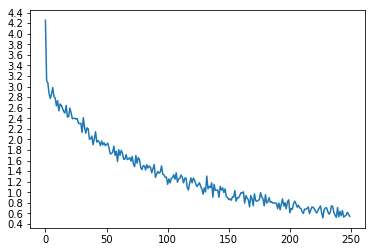

In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) 
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

show_plot(plot_losses)

## 评估效果

实际翻译的代码和训练类似，我们用上一个时刻的输出作为下一个时刻的输入，当遇到EOS时我们认为翻译结束。

In [35]:
def evaluate(sentence, max_length=MAX_LENGTH):
    input_variable = variable_from_sentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)

    decoder_input = Variable(torch.LongTensor([[SOS_token]])) # SOS
    decoder_context = Variable(torch.zeros(1, decoder.hidden_size))
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        decoder_context = decoder_context.cuda()

    decoder_hidden = encoder_hidden
    
    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)
    

    for di in range(max_length):
        decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
        decoder_attentions[di,:decoder_attention.size(2)] += decoder_attention.squeeze(0).squeeze(0).cpu().data

        topv, topi = decoder_output.data.topk(1)
        ni = topi.item()
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])
            
        # Next input is chosen word
        decoder_input = Variable(torch.LongTensor([[ni]]))
        if USE_CUDA: decoder_input = decoder_input.cuda()
    
    return decoded_words, decoder_attentions[:di+1, :len(encoder_outputs)]

我们可以测试一下效果：

In [36]:
def evaluate_randomly():
    pair = random.choice(pairs)
    
    output_words, decoder_attn = evaluate(pair[0])
    output_sentence = ' '.join(output_words)
    
    print('>', pair[0])
    print('=', pair[1])
    print('<', output_sentence)
    print('')

evaluate_randomly()

> je suis juste curieuse .
= i m just curious .
< i m just curious . <EOS>



## 注意力的可视化

注意力可以看出一种soft的对齐，我们可以观察模型怎么”对齐“源语言的词和目标语言的词。


In [37]:
def show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

def evaluate_and_show_attention(input_sentence):
    output_words, attentions = evaluate(input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    show_attention(input_sentence, output_words, attentions)

input = elle a cinq ans de moins que moi .
output = she s five years younger than me . <EOS>


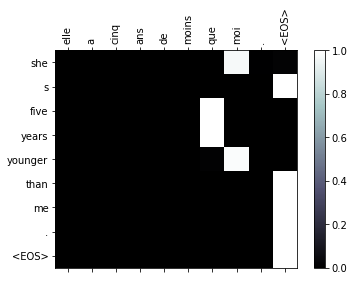

In [38]:
evaluate_and_show_attention("elle a cinq ans de moins que moi .")

input = elle est trop petit .
output = she s too short . <EOS>


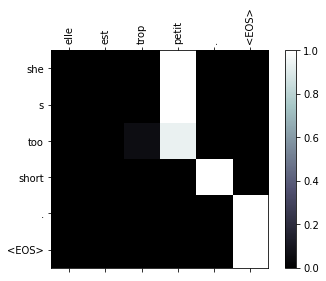

In [39]:
evaluate_and_show_attention("elle est trop petit .")

input = je ne crains pas de mourir .
output = i m not afraid of dying . <EOS>


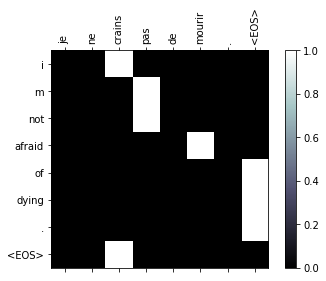

In [40]:
evaluate_and_show_attention("je ne crains pas de mourir .")

input = c est un jeune directeur plein de talent .
output = he s a talented talented person . <EOS>


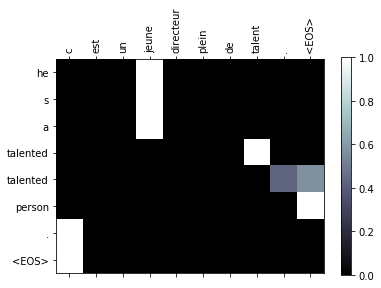

In [41]:
evaluate_and_show_attention("c est un jeune directeur plein de talent .")